In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# Experiment

In [35]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super(MyDataset, self).__init__()
        
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        index = torch.randperm(len(self.X))[index]
        return self.X[index], self.y[index]


device = "cuda" if torch.cuda.is_available() else "cpu"
device =  "cpu"
print(f"Using {device} device")

EXP = 1
def regression_fn(x, w1, w2):
    actual = (
        w2 * 
        torch.tanh((w1 -1) * x) * 
        torch.tanh((w1 + 1)**EXP * x) * 
        torch.tanh((w2 - (w1 + 1)**2) * x) 
    )
    local_minima_term = 0.5 * torch.sqrt(16 - (w1)**2 - ((w2 - 0.6))**2)
#     local_minima_term = 0.0 * torch.tanh((w2 - 0.6)**2 + (w1)**2)
#     local_minima_term = 0
    return actual + local_minima_term

class Model(nn.Module):
    def __init__(self, a=0.5, b=0.5):
        super(Model, self).__init__()
        self.w1 = torch.nn.Parameter(torch.tensor(float(a)))
        self.w2 = torch.nn.Parameter(torch.tensor(float(b)))
        
        self.w_history = [(self.w1.item(), self.w2.item())]
        self.loss_history = []
        
        
    def forward(self, x):
        return regression_fn(x, self.w1, self.w2)


class FeedForwardNetwork(nn.Module):
    def __init__(self, a=0.5, b=0.5):
        super(FeedForwardNetwork, self).__init__()
        self.w1 = torch.nn.Parameter(torch.tensor(float(a)))
        self.w2 = torch.nn.Parameter(torch.tensor(float(b)))
        
        self.w_history = [(self.w1.item(), self.w2.item())]
        self.loss_history = []
        
        
    def forward(self, x):
        return self.w2 * torch.tanh((self.w1 -1) * x) * torch.tanh((self.w1 + 1)**EXP * x) * torch.tanh((self.w2 - (self.w1 + 1)**2) * x)


def train(dataloader, model, loss_fn, optimiser):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
        model.w_history.append((model.w1.item(), model.w2.item()))
        model.loss_history.append(loss.item())
    return

            
            
def test(dataloader, model, loss_fn):
    return 
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader: 
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    return


Using cpu device


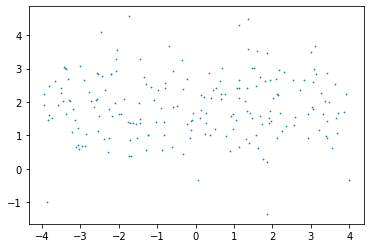

In [36]:
w_true = (1.5, 0.0)
model_true = Model(*w_true).to(device)

n = 200
X_train =  (torch.rand(n) - 1/2) * 8 # Uniform(-1, 1)
noise = torch.randn(n) * 1
y_train = model_true(X_train) + noise
# y_train = torch.cosh(X_train) / 10 + noise

training_data = MyDataset(X_train.detach().numpy(), y_train.detach().numpy())

# n_test = 100
# X_test = (torch.rand(n_test) - 1/2 * 10)
# noise_test = torch.randn(n_test)
# y_test = model_true(X_test) + noise_test
# testing_data = MyDataset(X_test, y_test)

plt.scatter(X_train.detach().numpy(), y_train.detach().numpy(), s=0.5)



Batch size = 40, w0=(1.5, 0.0)
Finished: w=[-1.312  0.071], w_init=(-1.8, 0.9), loss=5.450e-01 (init loss=7.958e-01)
Finished: w=[-1.356  0.043], w_init=(-1.8, -0.9), loss=9.594e-01 (init loss=8.648e-01)
Finished: w=[-1.233  0.024], w_init=(-1.3, 0.9), loss=7.177e-01 (init loss=1.461e+00)
Finished: w=[-0.99  -0.219], w_init=(-1.3, -0.9), loss=7.099e-01 (init loss=9.783e-01)
Finished: w=[-1.304  0.046], w_init=(-0.8, 0.9), loss=1.267e+00 (init loss=1.051e+00)
Finished: w=[-0.983 -0.307], w_init=(-0.8, -0.9), loss=6.118e-01 (init loss=1.085e+00)
Finished: w=[-1.081 -0.247], w_init=(-0.1, 0.9), loss=9.761e-01 (init loss=8.859e-01)
Finished: w=[-1.012 -0.275], w_init=(-0.1, -0.9), loss=1.029e+00 (init loss=1.389e+00)
Finished: w=[ 1.241 -0.059], w_init=(0.5, 0.9), loss=1.231e+00 (init loss=1.187e+00)
Finished: w=[ 1.171 -0.018], w_init=(0.5, -0.9), loss=8.104e-01 (init loss=1.119e+00)
Finished: w=[ 1.212 -0.107], w_init=(1.3, 0.9), loss=6.755e-01 (init loss=1.641e+00)
Finished: w=[ 1.124 -

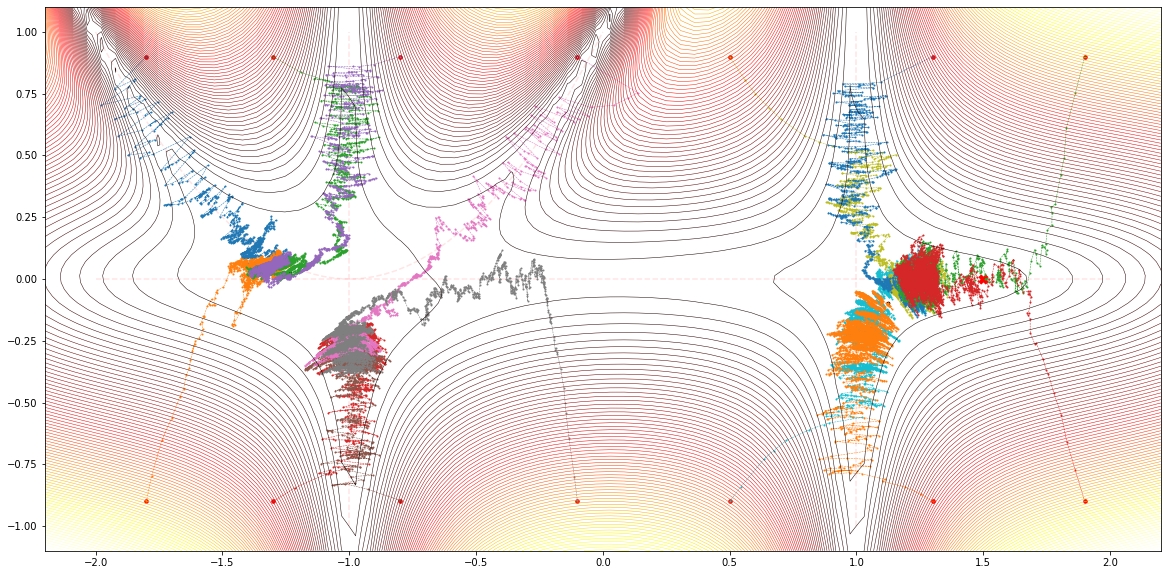

In [37]:
batch_size = max(n // 5, 1)
learning_rate = 0.1
print(f"Batch size = {batch_size}, w0={w_true}")
train_dataloader = DataLoader(training_data, batch_size=batch_size)
# test_dataloader = DataLoader(testing_data, batch_size=batch_size)
epochs = 500
loss_fn = nn.MSELoss()

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.scatter([w_true[0]], [w_true[1]], s=80, color="red", marker="X")

ax.vlines([-1, 1], ymin=-1, ymax=1, linestyles="dashed", color="red", alpha=0.1)
ax.hlines([0], xmin=-2, xmax=2, linestyles="dashed", color="red", alpha=0.1)
ax.plot(np.linspace(-2, 0), (np.linspace(-2, 0) + 1)**2, "r--", alpha=0.1)

model_rec = dict()
a_vals = [-1.8, -1.3, -0.8, -0.1, 0.5, 1.3, 1.9]
b_vals = [0.9, -0.9]
init_params = [(a, b) for a in a_vals for b in b_vals]
# init_params = [(np.random.rand() * np.random.randint(-1, 1), np.random.rand() * np.random.randint(-1, 1)), ]
for (a, b) in init_params:
    ax.scatter([a], [b], s=50, color="red", marker=".")
    model = Model(a, b).to(device)
    optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate)

    for t in range(epochs):
        train(train_dataloader, model, loss_fn, optimiser)
    #     test(test_dataloader, model, loss_fn)
    model_rec[(a, b)] = model

    hs = np.array(model.w_history)
    w_pred = hs[-1]
    loss = np.format_float_scientific(model.loss_history[-1], precision=3)
    init_loss = np.format_float_scientific(model.loss_history[0], precision=3)
    print(f"Finished: w={np.around(w_pred, 3)}, w_init={(a, b)}, loss={loss} (init loss={init_loss})")

    ax.plot(hs[:, 0], hs[:, 1], linestyle='--', marker='o', color=None, linewidth=0.5, markersize=1)
    ax.scatter([w_pred[0]], [w_pred[1]], s=30, color="black", marker=".")

d = 0.00
xmin, xmax = ax.get_xlim()
xmin -= d
xmax += d

ymin, ymax = ax.get_ylim()
ymin -= d
ymax += d

w1_axis = np.linspace(xmin, xmax, num=80)
w2_axis = np.linspace(ymin, ymax, num=80)
W1, W2 = np.meshgrid(w1_axis, w2_axis)
with torch.no_grad():
    Z = torch.stack(
        [(regression_fn(xval, torch.tensor(W1), torch.tensor(W2)) - yval)**2 
         for xval, yval in zip(X_train, y_train)]
    ).mean(axis=0)

ax.contour(W1, W2, -np.log(Z), levels=100, alpha=1, linewidths=0.5, cmap="hot_r")



dict_keys([(-1.8, 0.9), (-1.8, -0.9), (-1.3, 0.9), (-1.3, -0.9), (-0.8, 0.9), (-0.8, -0.9), (-0.1, 0.9), (-0.1, -0.9), (0.5, 0.9), (0.5, -0.9), (1.3, 0.9), (1.3, -0.9), (1.9, 0.9), (1.9, -0.9)])


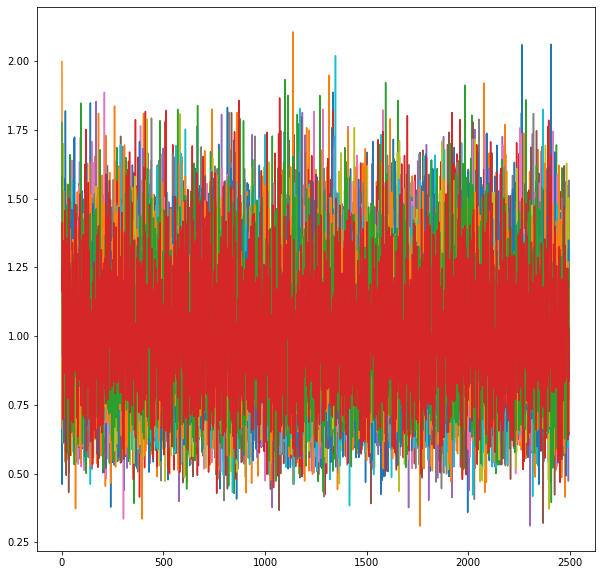

In [34]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
print(model_rec.keys())
for key, model in model_rec.items():
    ax.plot(np.clip(model.loss_history[1:], 0, 100))
# ax.plot(model_rec[(-0.1, -0.9)].loss_history[10:])

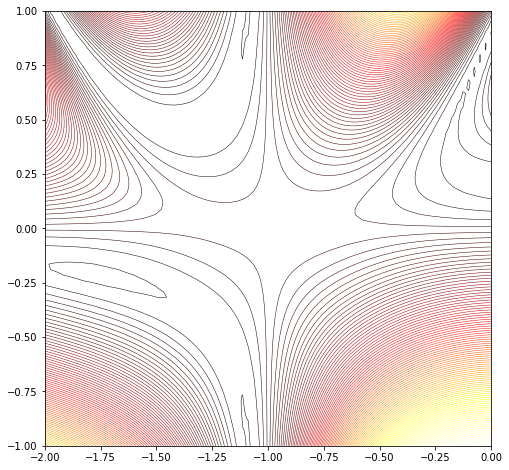

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
w1_axis = np.linspace(-2, 0.0, num=80)
w2_axis = np.linspace(-1, 1, num=80)
W1, W2 = np.meshgrid(w1_axis, w2_axis)
with torch.no_grad():
    Z = torch.stack(
        [(regression_fn(xval, torch.tensor(W1), torch.tensor(W2)) - yval)**2 
         for xval, yval in zip(X_train, y_train)]
    ).mean(axis=0)

ax.contour(W1, W2, -np.log(Z), levels=100, alpha=1, linewidths=0.5, cmap="hot_r")


In [69]:
def myplot(numlist, para):
    if para == False:
        for i in range(len(numlist)):
            line = '|'
            for j in range(len(numlist)):
                for num in numlist:
                    line += num*'@' + (5-num)*'.'
            return line
    
    

print(myplot([1,3,5,1], False))
print(myplot([1,3,5,1,2,4,1], True))
print(myplot([5,2, 3, 10, 0], False))
print(myplot([5,2, 3, 10, 0], True))

|@....@@@..@@@@@@....@....@@@..@@@@@@....@....@@@..@@@@@@....@....@@@..@@@@@@....
None
|@@@@@@@...@@@..@@@@@@@@@@.....@@@@@@@...@@@..@@@@@@@@@@.....@@@@@@@...@@@..@@@@@@@@@@.....@@@@@@@...@@@..@@@@@@@@@@.....@@@@@@@...@@@..@@@@@@@@@@.....
None
